# Single-Line Dataset: First Attempt

I have several thousand image files scattered across all of the sketchbook pages that I've scanned. My goal is to get all of the single-line drawings in one place so that I can convert them to the correct vector format needed to train a model that will produce new single-line drawings.

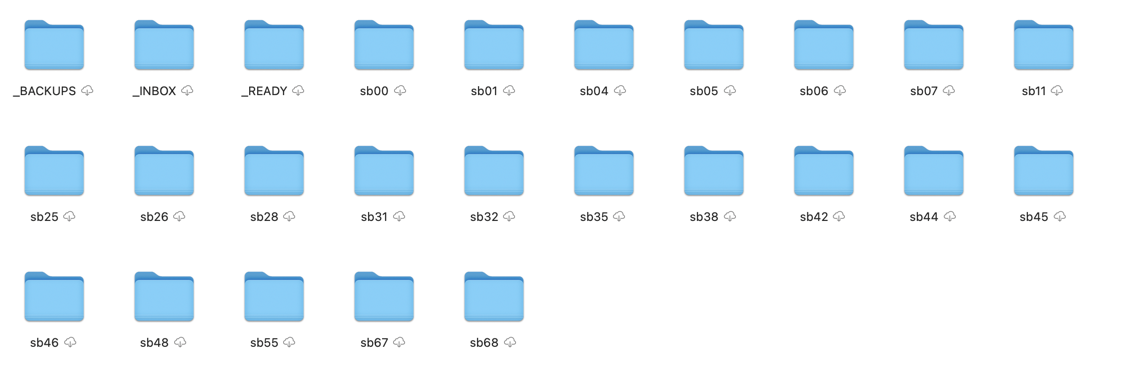

In [ ]:
#| hide
Image.open('./assets/singleline-dataset/01-folder-system/folder-icons.png')

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import math
from pathlib import Path

import pandas as pd
from fastai.vision.all import *
from PIL import Image

from singleline_stroke3.embeddings import *
from singleline_stroke3.fileorg import *

no env var SINGLELINE_DATA_HOME, defaulting to: None


## Sketchbook Data

My first problem is that the sketchbooks don't just contain single-line drawings. They also contain watercolor paintings and engineering diagrams, which I don't want to end up in the training data. Unfortunately, I didn't tag watercolors in advance. However, I marked which pages were diagrams/mindmaps/etc and put them in a subfolder called `notes` - the drawings (and watercolors) are in a folder called `art`.

My hunch is that I can use visual embeddings to group the images by similarity. Hopefully, clustering will make it easy to separate the watercolors.

In [ ]:
EXTERNAL_PARENT_DIR = Path('/Users/al/Dropbox/2-Areas/2-Sketchbooks')
EXTERNAL_SKETCHBOOKS_DIR = EXTERNAL_PARENT_DIR / 'sketchbooks'

for sketchbook_dir in EXTERNAL_SKETCHBOOKS_DIR.ls()[:5]:
    print(os.path.basename(sketchbook_dir))
    for subdir in sketchbook_dir.ls():
        if not os.path.isdir(subdir):
            continue
        print(f"\t{os.path.basename(subdir)}: {len(subdir.ls())} files")

sb67
	xtra: 48 files
	art: 117 files
	notes: 9 files
	cover: 1 files
sb69
	xtra: 6 files
	art: 126 files
	notes: 15 files
	cover: 4 files
sb05
	xtra: 26 files
	art: 83 files
	notes: 40 files
	cover: 1 files
sb68
	xtra: 14 files
	art: 128 files
	notes: 2 files
	cover: 1 files
sb50
	xtra: 45 files
	art: 107 files
	notes: 6 files
	cover: 2 files


`art` subfolders contain drawings, as mentioned earlier. For example:

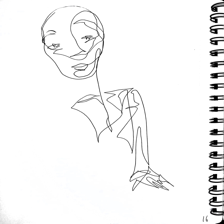

In [ ]:
#| hide
imgs = [Image.open(f) for f in get_image_files(EXTERNAL_SKETCHBOOKS_DIR / 'sb67' / 'art')[:5]]
imgs[0].resize((224,224))

`notes` subfolders contain diagrams, mindmaps, and anything else technical I'm working on. I used to have a separate notebook for these, but I got tired of carrying around an extra sketchbook everywhere I go, so at some point they just ended up merging with my art practice. Here's an example of what one page in `notes` might look like:

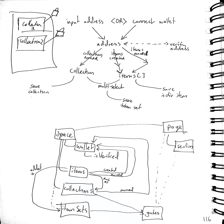

In [ ]:
#| hide
imgs = [Image.open(f) for f in get_image_files(EXTERNAL_SKETCHBOOKS_DIR / 'sb67' / 'notes')[:5]]
imgs[2].resize((224,224))

`cover` contains a scan of the notebook cover. Each cover at least has a post-it with the sketchbook ID number and the start/end dates of when I used that sketchbook. Often I'll make a little collage on the front of the notebook with airplane tickets / stickers / scraps of paper relevant to somewhere I traveled when I used that sketchbook.

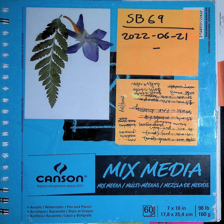

In [ ]:
#| hide
imgs = [Image.open(f) for f in get_image_files(EXTERNAL_SKETCHBOOKS_DIR / 'sb69' / 'cover')]
imgs[0].resize((224,224))

`xtra` contains any bad scans or funny bloopers from my scanning process. I kind of like the scans with my hands in them and thought they might be useful for a future project, so I kept them in their own folder. Here's an example:

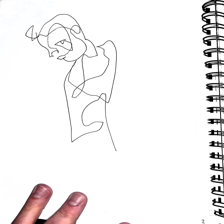

In [ ]:
#| hide
imgs = [Image.open(f) for f in get_image_files(EXTERNAL_SKETCHBOOKS_DIR / 'sb67' / 'xtra')]
imgs[0].resize((224,224))

## Computing Embeddings




In [ ]:
EXTERNAL_DATA_HOME = EXTERNAL_PARENT_DIR / 'singleline_data'
EPOCH = SketchbookEpoch(epoch='20231214', data_home=EXTERNAL_DATA_HOME)

CURR_01_FLAT = EPOCH.dir_01_FLAT()
CURR_02_CATEGORIZED = EPOCH.dir_02_CATEGORIZED()
CURR_03_HAND = EPOCH.dir_03_HANDLABELED()

print(CURR_01_FLAT)

Path('/Users/al/Dropbox/2-Areas/2-Sketchbooks/singleline_data/raster/epoch-20231214/01_FLAT')

In [ ]:
# """ code to train original model """

# # dataloaders = sketchbook_dataloaders(sample_path / "01_FLAT")
# # print(dataloaders.vocab)
# # learn = vision_learner(dataloaders, resnet34, metrics=error_rate)
# # learn = sketchbook_resnet34(SAMPLE_SKETCHBOOKS_DIR)
# # learn.fine_tune(6)
# # learn.recorder.plot_loss()
# # learn.save(PRETRAINED_CHECKPOINT) ## TODO: this'll be at a different path than PRETRAINED_MODEL_PATH

In [ ]:
# dir_to_embed = DATA_HOME / "raster/epoch-20231214/01_FLAT"
dir_to_embed = CURR_01_FLAT

path = Path(dir_to_embed)
files = get_image_files(path)
len(files)

batched_fnames, ordered_dls = batch_fnames_and_images(dir_to_embed)

total items: 2922, num batches: 46


In [ ]:
learn = load_resnet(
    data_home=EXTERNAL_DATA_HOME,
    model_path=PRETRAINED_MODEL_PATH,
    model_checkpoint=PRETRAINED_CHECKPOINT,
)

learn.model[-1]

In [ ]:
rows = []
for x in embed_dir(dir_to_embed, learn, strip_dir=DATA_HOME):
    rows.append(x)
df = pd.DataFrame(rows)
print(f"num rows: {len(df)}")
df.head()

(24, 0, 24)

In [ ]:
embeddings_fname = f"{str(dir_to_embed)}.tsv"
df.to_csv(embeddings_fname, index=False, sep="\t", header=True)
print(f"wrote {embeddings_fname}")

df = pd.read_csv(embeddings_fname, delimiter="\t", index_col="idx")
df.head()

embs = pd_series_to_embs(df.emb_csv)
print(embs.shape)

['art', 'cover', 'notes', 'priv', 'xtra']

### clustering

In [ ]:
kmeans = train_kmeans(embs, ncentroids=16)

# note: these will need to be populated and re-saved once we've labeled the clusters.
cluster_to_label = {}

save_centroids(centroids=kmeans.centroids, cluster_to_label=cluster_to_label)

In [ ]:
# centroids, cluster_to_label = load_centroids(
#     data_home=singleline_data_home('../data_home'),
#     model_path=PRETRAINED_MODEL_PATH
# )
# assigner = cluster_assigner(centroids, cluster_to_label)

### assign clusters and save to disk

In [ ]:
# assign nearest centroid to each
embs = pd_series_to_embs(df.emb_csv)
knn_dist, knn_clusterid, knn_label = assigner(embs)
knn_label[:5], knn_clusterid[:5]

In [ ]:
categorized_fname = EPOCH.tsv_02_CATEGORIZED()
categorized_dir = EPOCH.dir_02_CATEGORIZED()

df["knn_dist"] = knn_dist
df["knn_clusterid"] = knn_clusterid
df["knn_label"] = knn_label

df["categorized_path"] = df.apply(
    lambda row: os.path.join(row["knn_label"], row["indiv_fname"]), axis=1
)

if 'emb_csv' in df.columns:
    del df['emb_csv']

df.head()

In [ ]:
clusters_fname = f"{dir_to_embed}_clusters.tsv"

# NOTE: when saving embeddings CSV, idx was a regular column (not a pandas 'index').
# When reloaded, 'idx' was made the index column. TODO: make original DF use 'idx' as index,
# so saving and reloading code is identical.
df.to_csv(clusters_fname, index=True, index_label="idx", sep="\t", header=True)

cdf = pd.read_csv(clusters_fname, delimiter="\t", index_col="idx")
cdf.knn_clusterid.hist()

In [ ]:
cdf.head()

abs_fname  \
idx                                                                                        
0      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p043.jpg   
1      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb67p021.jpg   
2    /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/notes/sb06p023.jpg   
3      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb25p227.jpg   
4      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb07p104.jpg   

              rel_fname  label pred_label  pred_idx  \
idx                                                   
0      art/sb77p043.jpg    art       xtra         4   
1      art/sb67p021.jpg    art       xtra         4   
2    notes/sb06p023.jpg  notes       xtra         4   
3      art/sb25p227.jpg    art       xtra         4   
4      art/sb07p104.jpg    art       xtra         4   

                                       pred_probs  \
idx                                                 
0    0.168532,0.008473,0.008068,0.016940,0.797986   
1    0.170976,0.008673,0.008480,0.017028,0.794843   
2    0.171455,0.008462,0.007966,0.016696,0.795421   
3    0.158396,0.008277,0.007424,0.016584,0.809319   
4    0.177406,0.008799,0.008245,0.017177,0.788373   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     emb_csv  \
idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0    -0.6198182,-0.5714155,-0.6871516,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,1.4904574,-0.72562873,-0.662768,-0.6266761,0.6913696,0.054546177,-0.5467274,-0.6520286,0.117179275,0.94330966,0.5815062,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.4584825,-0.3818994,-0.5750927,-0.73986673,-0.45211998,-0.6141643,-0.67007643,-0.52171326,-0.4592305,1.4788612,-0.6186755,0.799198,-0.57338566,-0.17778617,0.10336053,0.093812525,0.17924881,-0.6189488,-0.6682474,2.1040225,-0.59257406,1.6553459,-0.6001429,0.5109105,0.19352531,-0.2517513,-0.66552746,-0.6482407,-0.4732...   
1    1.1073987,0.3512016,-0.73929733,-0.6553513,1.7477593,-0.65341413,0.32179314,-0.4896673,-0.1797334,-0.42715576,1.3163843,-0.72562873,-0.61387855,-0.6266761,-0.35361218,0.37611246,-0.08771938,-0.5262803,0.9261699,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.32559583,-0.6690378,-0.4518578,0.51828945,-0.4238917,-0.45211998,-0.16527033,-0.67007643,1.0136865,-0.4592305,-0.600525,-0.060860336,-0.19446748,-0.24127388,2.2282472,1.8003348,-0.61049384,0.39795423,0.2626753,-0.6682474,-0.75794554,-0.59257406,0.80257696,-0.6001429,-0.651804,-0.028328001,0.53641737,-0.6501347,-0.6482407,0....   
2    2.071539,1.9655468,-0.73929733,0.5748948,3.170734,-0.65341413,0.63399774,1.729534,-0.7537334,0.84828806,-0.62038505,-0.72562873,-0.662768,-0.6266761,-0.68991846,2.328189,0.38060355,1.1197739,0.73272705,-0.6497359,-0.64108604,1.9738588,0.97

### WIP: visualize clusters

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


def show_cluster(clusters_df, clusters, idx):
    imgs = [Image.open(clusters_df.iloc[i].abs_fname) for i in clusters[idx]]

    fig = plt.figure(figsize=(16.0, 16.0))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(4, 4),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [ ]:
show_cluster(clusters_df=df, clusters=I, idx=0)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


def show_all_clusters(clusters_df, clusters, cluster_idxs=None, title=None):
    select_idxs = cluster_idxs if cluster_idxs else range(len(clusters))
    num_clusters = len(select_idxs)
    examples_per_cluster = 16
    fig = plt.figure(figsize=(16.0, float(num_clusters)))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(num_clusters, examples_per_cluster),
        axes_pad=0.02,
    )
    for row, cluster_idx in enumerate(select_idxs):
        imgs = [
            Image.open(clusters_df.iloc[i].abs_fname) for i in clusters[cluster_idx]
        ]

        for col, im in enumerate(imgs):
            total_idx = col + row * examples_per_cluster
            ax = grid[total_idx]
            ax.grid = False
            ax.set_xticks([])
            ax.set_yticks([])
            if col == 0:
                ax.set_ylabel(f"{cluster_idx}  ", rotation=0)
            ax.imshow(im)
    if title:
        fig.suptitle(
            title
            if cluster_idxs is None
            else f"{title} (Cluster IDs: {','.join([str(i) for i in select_idxs])})"
        )
    plt.show()

In [ ]:
show_all_clusters(clusters_df=df, clusters=I)

In [ ]:
DRAWING_CLUSTERS = [0, 2, 3, 4, 8, 13, 14, 15]
WATERCOLOR_CLUSTERS = [5, 7, 11]
NOTES_CLUSTERS = [9, 12]
BAD_SCANS = [1, 6, 10]
COVERS = []

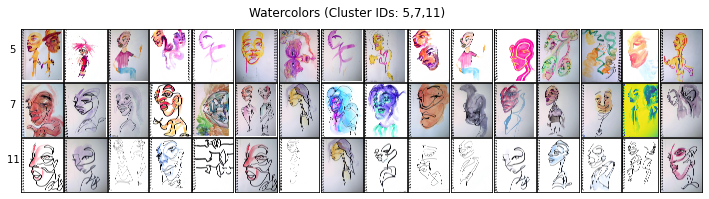

In [ ]:
show_all_clusters(
    clusters_df=df, clusters=I, cluster_idxs=WATERCOLOR_CLUSTERS, title="Watercolors"
)

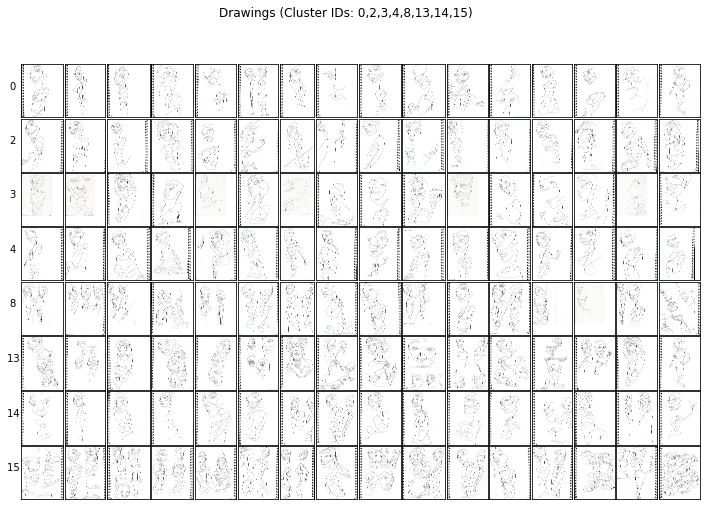

In [ ]:
show_all_clusters(
    clusters_df=df, clusters=I, cluster_idxs=DRAWING_CLUSTERS, title="Drawings"
)

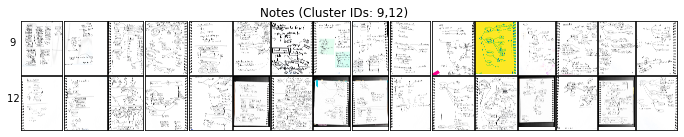

In [ ]:
show_all_clusters(
    clusters_df=df, clusters=I, cluster_idxs=NOTES_CLUSTERS, title="Notes"
)

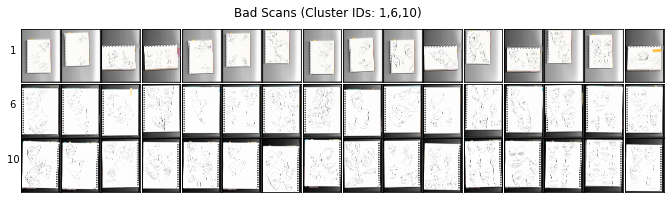

In [ ]:
show_all_clusters(clusters_df=df, clusters=I, cluster_idxs=BAD_SCANS, title="Bad Scans")

### T-SNE

In [ ]:
from sklearn.manifold import TSNE

y = list(df.label)
labels = list(set(y))
label_mapping = {label: i for i, label in enumerate(labels)}
y_idx = [label_mapping[label] for label in y]
print(labels, y_idx[:5])

X = embs
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

['art', 'cover', 'notes'] [0, 0, 2, 0, 0]


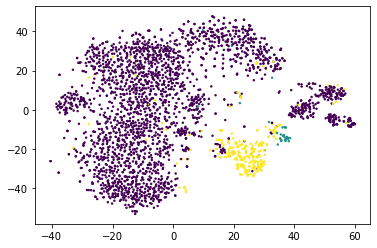

In [ ]:
fig = plt.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y_idx, s=2)

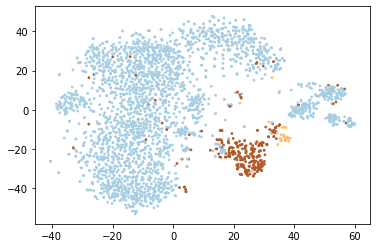

In [ ]:
fig = plt.scatter(
    x=X_tsne[:, 0], y=X_tsne[:, 1], c=y_idx, s=3.0, cmap=plt.get_cmap("Paired")
)

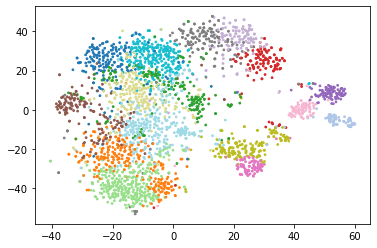

In [ ]:
fig = plt.scatter(
    x=X_tsne[:, 0], y=X_tsne[:, 1], c=df.cluster, s=3.0, cmap=plt.get_cmap("tab20")
)

In [ ]:
def metacluster(x):
    if x in DRAWING_CLUSTERS:
        return 0
    if x in WATERCOLOR_CLUSTERS:
        return 1
    if x in NOTES_CLUSTERS:
        return 2
    if x in BAD_SCANS:
        return 3
    if x in COVERS:
        return 4
    else:
        raise Exception(f"invalid cluster: {x}")


metacluster_id_to_name = {
    0: "0_drawings",
    1: "1_watercolors",
    2: "2_notes",
    3: "3_badscans",
    4: "4_covers",
}

metacluster_name_to_id = {v: k for k, v in metacluster_id_to_name.items()}
metacluster_name_to_id

{'0_drawings': 0,
 '1_watercolors': 1,
 '2_notes': 2,
 '3_badscans': 3,
 '4_covers': 4}

In [ ]:
df["metacluster"] = [metacluster(x) for x in list(df.cluster)]
df["metacluster_name"] = [metacluster_id_to_name(i) for i in list(df.metacluster)]

df.head()

abs_fname  \
idx                                                                                        
0      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p043.jpg   
1      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb67p021.jpg   
2    /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/notes/sb06p023.jpg   
3      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb25p227.jpg   
4      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb07p104.jpg   

              rel_fname  label pred_label  pred_idx  \
idx                                                   
0      art/sb77p043.jpg    art       xtra         4   
1      art/sb67p021.jpg    art       xtra         4   
2    notes/sb06p023.jpg  notes       xtra         4   
3      art/sb25p227.jpg    art       xtra         4   
4      art/sb07p104.jpg    art       xtra         4   

                                       pred_probs  \
idx                                                 
0    0.168532,0.008473,0.008068,0.016940,0.797986   
1    0.170976,0.008673,0.008480,0.017028,0.794843   
2    0.171455,0.008462,0.007966,0.016696,0.795421   
3    0.158396,0.008277,0.007424,0.016584,0.809319   
4    0.177406,0.008799,0.008245,0.017177,0.788373   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     emb_csv  \
idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0    -0.6198182,-0.5714155,-0.6871516,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,1.4904574,-0.72562873,-0.662768,-0.6266761,0.6913696,0.054546177,-0.5467274,-0.6520286,0.117179275,0.94330966,0.5815062,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.4584825,-0.3818994,-0.5750927,-0.73986673,-0.45211998,-0.6141643,-0.67007643,-0.52171326,-0.4592305,1.4788612,-0.6186755,0.799198,-0.57338566,-0.17778617,0.10336053,0.093812525,0.17924881,-0.6189488,-0.6682474,2.1040225,-0.59257406,1.6553459,-0.6001429,0.5109105,0.19352531,-0.2517513,-0.66552746,-0.6482407,-0.4732...   
1    1.1073987,0.3512016,-0.73929733,-0.6553513,1.7477593,-0.65341413,0.32179314,-0.4896673,-0.1797334,-0.42715576,1.3163843,-0.72562873,-0.61387855,-0.6266761,-0.35361218,0.37611246,-0.08771938,-0.5262803,0.9261699,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.32559583,-0.6690378,-0.4518578,0.51828945,-0.4238917,-0.45211998,-0.16527033,-0.67007643,1.0136865,-0.4592305,-0.600525,-0.060860336,-0.19446748,-0.24127388,2.2282472,1.8003348,-0.61049384,0.39795423,0.2626753,-0.6682474,-0.75794554,-0.59257406,0.80257696,-0.6001429,-0.651804,-0.028328001,0.53641737,-0.6501347,-0.6482407,0....   
2    2.071539,1.9655468,-0.73929733,0.5748948,3.170734,-0.65341413,0.63399774,1.729534,-0.7537334,0.84828806,-0.62038505,-0.72562873,-0.662768,-0.6266761,-0.68991846,2.328189,0.38060355,1.1197739,0.73272705,-0.6497359,-0.64108604,1.9738588,0.97

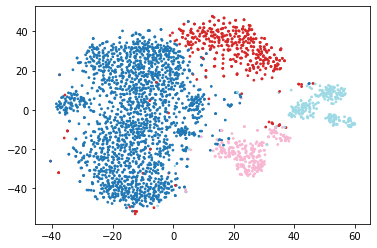

In [ ]:
fig = plt.scatter(
    x=X_tsne[:, 0], y=X_tsne[:, 1], c=df.metacluster, s=3.0, cmap=plt.get_cmap("tab20")
)

### categorizing clusters, bucketing images into new dir

Thinking out loud:
- how to make these scripts idempotent?
- ideally, when I get these images bucketed by directory, I can manually "re-label" any incorrect ones by moving them to a new dir.

when I add more files at the input stage, it'd be nice if I could re-run the scripts:
- flatten should copy over the new files (maybe it doesn't need to replace - that'd be faster)
- vis-cluster not recategorizing the ones I've already labeled would be helpful.
    - do I need to save `kmeans.faiss` and/or `index.faiss` for this to work?

In [ ]:
# # dir_to_embed = singleline_data_home() / "raster/epoch-20231214/01_FLAT"
# dest_dir = (
#     singleline_data_home() / "raster/epoch-20231214/02_VISUAL_CATEGORIES"
# )

# # add useful metadata about where we're going to move the files to
# df["indiv_fname"] = df.rel_fname.map(lambda f: os.path.basename(f))
# df["visual_rel_path"] = df.apply(
#     lambda row: os.path.join(row["metacluster_name"], row["indiv_fname"]), axis=1
# )
# df["visual_abs_path"] = df.visual_rel_path.map(lambda f: os.path.join(dest_dir, f))

# # print(df["indiv_fname"][0:3])
# # print(df["visual_rel_path"][0:3])
# # print(df["visual_abs_path"][0:3])

In [ ]:
# metaclusters_fname = f"{dir_to_embed}/metaclusters.tsv"
# df.to_csv(metaclusters_fname, index=True, index_label="idx", sep="\t", header=True)

# metaclusters_df = pd.read_csv(metaclusters_fname, delimiter="\t", index_col="idx")
# metaclusters_df.head()

abs_fname  \
idx                                                                                        
0      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p043.jpg   
1      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb67p021.jpg   
2    /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/notes/sb06p023.jpg   
3      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb25p227.jpg   
4      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb07p104.jpg   

              rel_fname  label pred_label  pred_idx  \
idx                                                   
0      art/sb77p043.jpg    art       xtra         4   
1      art/sb67p021.jpg    art       xtra         4   
2    notes/sb06p023.jpg  notes       xtra         4   
3      art/sb25p227.jpg    art       xtra         4   
4      art/sb07p104.jpg    art       xtra         4   

                                       pred_probs  \
idx                                                 
0    0.168532,0.008473,0.008068,0.016940,0.797986   
1    0.170976,0.008673,0.008480,0.017028,0.794843   
2    0.171455,0.008462,0.007966,0.016696,0.795421   
3    0.158396,0.008277,0.007424,0.016584,0.809319   
4    0.177406,0.008799,0.008245,0.017177,0.788373   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     emb_csv  \
idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0    -0.6198182,-0.5714155,-0.6871516,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,1.4904574,-0.72562873,-0.662768,-0.6266761,0.6913696,0.054546177,-0.5467274,-0.6520286,0.117179275,0.94330966,0.5815062,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.4584825,-0.3818994,-0.5750927,-0.73986673,-0.45211998,-0.6141643,-0.67007643,-0.52171326,-0.4592305,1.4788612,-0.6186755,0.799198,-0.57338566,-0.17778617,0.10336053,0.093812525,0.17924881,-0.6189488,-0.6682474,2.1040225,-0.59257406,1.6553459,-0.6001429,0.5109105,0.19352531,-0.2517513,-0.66552746,-0.6482407,-0.4732...   
1    1.1073987,0.3512016,-0.73929733,-0.6553513,1.7477593,-0.65341413,0.32179314,-0.4896673,-0.1797334,-0.42715576,1.3163843,-0.72562873,-0.61387855,-0.6266761,-0.35361218,0.37611246,-0.08771938,-0.5262803,0.9261699,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.32559583,-0.6690378,-0.4518578,0.51828945,-0.4238917,-0.45211998,-0.16527033,-0.67007643,1.0136865,-0.4592305,-0.600525,-0.060860336,-0.19446748,-0.24127388,2.2282472,1.8003348,-0.61049384,0.39795423,0.2626753,-0.6682474,-0.75794554,-0.59257406,0.80257696,-0.6001429,-0.651804,-0.028328001,0.53641737,-0.6501347,-0.6482407,0....   
2    2.071539,1.9655468,-0.73929733,0.5748948,3.170734,-0.65341413,0.63399774,1.729534,-0.7537334,0.84828806,-0.62038505,-0.72562873,-0.662768,-0.6266761,-0.68991846,2.328189,0.38060355,1.1197739,0.73272705,-0.6497359,-0.64108604,1.9738588,0.97

### moving files

In [ ]:
# test_files = get_image_files(dir_to_embed)
# test_files

no env var SINGLELINE_DATA_HOME, defaulting to: None


In [ ]:
# L(os.path.basename(f) for f in test_files)

In [ ]:
# "NON_EXISTENT" in L(os.path.basename(f) for f in test_files), "sb38p036.jpg" in L(
#     os.path.basename(f) for f in test_files
# )

In [ ]:
# existing_files = get_image_files(dest_dir)

In [ ]:
# existing_files

In [ ]:
# import math
# import os
# import shutil

# from PIL import Image

# """
# inputs:
# - dest_dir
# - metaclusters_df
# """


# existing_files = L(os.path.basename(f) for f in get_image_files(dest_dir))

# for idx in range(len(metaclusters_df)):
#     row = metaclusters_df.iloc[idx]

#     indiv_fname = row.indiv_fname
#     if indiv_fname in existing_files:
#         print(f"skipping {indiv_fname}")
#         continue

#     orig_abs_path = row.abs_fname
#     visual_abs_path = row.visual_abs_path

#     visual_dir = os.path.dirname(visual_abs_path)
#     if not os.path.isdir(visual_dir):
#         os.makedirs(visual_dir)

#     print(f"writing to {visual_abs_path}")
#     shutil.copy(orig_abs_path, visual_abs_path)
#     # try:
#     #     img = Image.open(f"/Users/al/Dropbox/2-Areas/2-Sketchbooks/{row.fname}")
#     #     crop_amt = math.floor(img.size[0] * 20 / 224)
#     #     cropped_img = img.crop((crop_amt, 0, img.size[0] - crop_amt, img.size[1]))
#     #     # cropped_img
#     #     cropped_img.save(out_path)
#     # except Exception as e:
#     #     print(e)

## hand-labeling (+ braindump)

Since the clusters weren't 100% accurate, I hand-edited the clusters (by going through each folder, tagging anything that belonged in a different folder, then grouping the folder by tags and moving out any tagged files).

First I copied this directory:
```
full-v2/02_VISUAL_CATEGORIES
```

to
```
full-v2/03_VISUAL_HAND_LABELED
```

So, I should probably
- [ ] iterate through the files in `metaclusters_df` and mark what their updated relpaths are
- [ ] save the result to a TSV file (in `03_VISUAL_HAND_LABELED`?)
- [ ] update my cropping code below to use the more accurately selected files when populating `10_SIMPLE_CROP`
- [ ] (maybe) also save the filepath of the cropped files?

Then, if I want, I could 
- re-cluster within the watercolors and within the drawings. Perhaps cluster on the cropped versions? That might give me a starting point for filtering down to a more similar set of drawings.
- Alternatively, I might get more bang for my buck by going into vector land and splitting the non-overlapping strokes into separate drawings
- Also: can i find and filter out all diagchains / tower drawings? those might clarify the signal a bit

And it'd be really fun (!) to...
- [Visualizing Data using the Embedding Projector in TensorBoard  |  TensorFlow](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin)
- [Taking the TensorBoard Embedding Projector to the Next Level](https://towardsdatascience.com/taking-the-tensorboard-embedding-projector-to-the-next-level-bde53deb6bb7)
- though I'll want clear PNG's for the sprites. perhaps this is easier to do after I've vectorized and re-saved to SVG.

I'm also curious whether there's anything automated I can do to:
- do "face detection", so I'm only working with actual drawings of faces?
- full-train on quickdraw faces dataset, then fine-tune on my face drawings?
- detect bounding boxes for handwriting on the page (potentially crop it out at vectorization time?)
- detect edge of sketchbook pages?
- detect poorly scanned / crop to just the page?

Side note re: the handlabeling process:
- why didn't "covers" get their own cluster?
- where did all the "xtra" ones go? were they in 'badcovers' (which I didn't manually sort through yet)

### first, get a mapping of `indiv_fname` to the relative path within `03_VISUAL_HAND_LABELED`

In [ ]:
# handlabeled_dir = (
#     singleline_data_home() / "raster/epoch-20231214/03_VISUAL_HAND_LABELED"
# )

# handlabeled_files = get_image_files(handlabeled_dir)
# handlabeled_files

In [ ]:
# def basename_and_parent(f):
#     base = os.path.basename(f)
#     parent_abs = os.path.dirname(f)
#     parent_base = os.path.basename(parent_abs)
#     handlabeled_relpath = os.path.join(parent_base, base)
#     return base, handlabeled_relpath


# label_mapping = {
#     base: parent for base, parent in [basename_and_parent(f) for f in handlabeled_files]
# }

### infer hand-chosen label

In [ ]:
# metaclusters_df.head()

In [ ]:
# metaclusters_df["handlabeled_rel_path"] = metaclusters_df.indiv_fname.map(
#     lambda f: label_mapping[f]
# )
# print(metaclusters_df.handlabeled_rel_path[:5])

# metaclusters_df["handlabeled_abs_path"] = metaclusters_df.handlabeled_rel_path.map(
#     lambda p: os.path.join(handlabeled_dir, p)
# )
# print(metaclusters_df.handlabeled_abs_path[:5])

# metaclusters_df[
#     "handlabeled_metacluster_name"
# ] = metaclusters_df.handlabeled_rel_path.map(lambda p: os.path.dirname(p))
# print(metaclusters_df.handlabeled_metacluster_name[:5])

# metaclusters_df[
#     "handlabeled_metacluster_id"
# ] = metaclusters_df.handlabeled_metacluster_name.map(
#     lambda n: metacluster_name_to_id[n]
# )

In [ ]:
# # note to self: give this a better name
# # - not calling it "metacluster", instead -> "visual category"? "category"?
# # - "metacluster_id"

# # comparing the id's
# metaclusters_df[["handlabeled_metacluster_id", "metacluster"]][:5]

In [ ]:
# # did the label change when I had to hand-label?
# metaclusters_df["handlabeled_metacluster_was_correct"] = metaclusters_df.apply(
#     lambda row: row.metacluster == row.handlabeled_metacluster_id, axis=1
# )[:20]
# print(metaclusters_df.handlabeled_metacluster_was_correct[:10])

### precompute path to which the image is going to get preprocessed/cropped, save DF as `handlabeled.tsv`

In [ ]:
# preprocessing_dir = (
#     singleline_data_home() / "raster/epoch-20231214/10_SIMPLE_CROP"
# )

# metaclusters_df["preprocessed_abs_path"] = metaclusters_df.handlabeled_rel_path.map(
#     lambda p: os.path.join(preprocessing_dir, p)
# )
# metaclusters_df.preprocessed_abs_path[:5]

In [ ]:
# metaclusters_df.head()

In [ ]:
# handlabeled_tsv_fname = f"{handlabeled_dir}/handlabeled.tsv"

# metaclusters_df.to_csv(
#     handlabeled_tsv_fname, index=True, index_label="idx", sep="\t", header=True
# )

# handlabeled_df = pd.read_csv(handlabeled_tsv_fname, delimiter="\t", index_col="idx")

# hdf = handlabeled_df
# hdf.head()

### side quest: how accurate was clustering for separating the categories I care about?

Time to make a classification report!

- [sklearn.metrics.classification\_report — scikit-learn 1.3.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- [sklearn.metrics.confusion\_matrix — scikit-learn 1.3.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
- https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
- [sklearn.metrics.ConfusionMatrixDisplay — scikit-learn 1.3.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

In [ ]:
# from sklearn.metrics import classification_report

# target_names = list(metacluster_id_to_name.values())

# y_true = metaclusters_df.handlabeled_metacluster_id
# y_pred = metaclusters_df.metacluster

# print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

   0_drawings       0.95      0.96      0.96      1923
1_watercolors       0.83      0.93      0.88       404
      2_notes       0.86      0.79      0.82       287
   3_badscans       1.00      0.99      0.99       269
     4_covers       0.00      0.00      0.00        39

     accuracy                           0.93      2922
    macro avg       0.73      0.73      0.73      2922
 weighted avg       0.92      0.93      0.92      2922



/Users/al/miniconda3_m1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/al/miniconda3_m1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/al/miniconda3_m1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
# disp.plot()
# # plt.show()

In [ ]:
# for idx in range(len(metaclusters_df)):

#     if idx > 10:
#         break

#     row = metaclusters_df.iloc[idx]

#     indiv_fname = row.indiv_fname

#     handlabeled_rel_path = label_mapping[indiv_fname]
#     handlabeled_metacluster_name = os.path.dirname(handlabeled_rel_path)
#     print(handlabeled_rel_path, handlabeled_metacluster_name, row.metacluster_name)

## processing

### v0: dummy crop (both sides, by a fixed percentage)

In [ ]:
# preprocessing_dir = (
#     singleline_data_home() / "raster/epoch-20231214/10_SIMPLE_CROP"
# )  # <-- this was defined earlier.
existing_files = L(os.path.basename(f) for f in get_image_files(preprocessing_dir))

crop_frac = 20.0 / 224
print(f"using crop_frac={crop_frac}")

for idx in range(len(metaclusters_df)):

    # if idx > 10:
    #     break

    row = metaclusters_df.iloc[idx]
    # if row.metacluster_name != "0_drawings":
    #     # print(f"ignore {row.metacluster_name}")
    #     continue

    indiv_fname = row.indiv_fname
    if indiv_fname in existing_files:
        print(f"skipping {indiv_fname}")
        continue

    # handlabeled_rel_path = row.handlabeled_rel_path
    # preproc_abs_path = os.path.join(preprocessing_dir, handlabeled_rel_path)
    preproc_abs_path = row.preprocessed_abs_path
    # print(preproc_abs_path)

    preproc_dir = os.path.dirname(preproc_abs_path)
    if not os.path.isdir(preproc_dir):
        os.makedirs(preproc_dir)

    handlabeled_abs_path = row.handlabeled_abs_path
    print(f"writing from {handlabeled_abs_path} to {preproc_abs_path}")

    try:
        img = Image.open(handlabeled_abs_path)
        print(img.size)
        crop_amt = math.floor(
            img.size[0] * crop_frac
        )  # compute number of pixels to crop (roughly 8% of page size)
        cropped_img = img.crop((crop_amt, 0, img.size[0] - crop_amt, img.size[1]))
        # cropped_img
        cropped_img.save(preproc_abs_path)
    except Exception as e:
        print(e)

using crop_frac=0.08928571428571429
writing from /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb77p043.jpg to /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb77p043.jpg
(1920, 2461)
writing from /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb67p021.jpg to /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb67p021.jpg
(2006, 2597)
writing from /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/3_badscans/sb06p023.jpg to /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/3_badscans/sb06p023.jpg
(1700, 2338)
writing from /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb25p227.jpg to /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p227.jpg
(1364, 2024)
writing from /Users/al/Dropbox/2-Areas/2-Sketchb

### get embeddings for the cropped images

In [ ]:
cropped_emb_rows = []
for x in embed_dir(
    preprocessing_dir, learn
):  # important: use "preprocessing_dir" so we get embeds of the cropped imgs
    cropped_emb_rows.append(x)
cropped_embd_df = pd.DataFrame(cropped_emb_rows)
print(f"num rows: {len(cropped_embd_df)}")
cropped_embd_df.head()

total items: 2922, num batches: 46


num rows: 2922


idx  \
0    0   
1    1   
2    2   
3    3   
4    4   

                                                                                                                     abs_fname  \
0                              /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p199.jpg   
1                              /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p043.jpg   
2                           /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/1_watercolors/sb26p011.jpg   
3  /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/2_notes/sb46p090-fundraising-deck-illustrations.jpg   
4                              /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb38p002.jpg   

                                             rel_fname          label  \
0                              0_drawings/sb25p199.jpg     0_drawings   
1                              0_drawings/sb25p043.jpg     0_drawings   
2                           1_watercolors/sb26p011.jpg  1_watercolors   
3  2_notes/sb46p090-fundraising-deck-illustrations.jpg        2_notes   
4                              0_drawings/sb38p002.jpg     0_drawings   

  pred_label pred_idx                                    pred_probs  \
0       xtra        4  0.163658,0.008260,0.008051,0.016511,0.803520   
1       xtra        4  0.153572,0.008271,0.007657,0.016232,0.814268   
2       xtra        4  0.168120,0.008694,0.008156,0.016850,0.798180   
3       xtra        4  0.171107,0.008683,0.008175,0.016800,0.795234   
4       xtra        4  0.159390,0.008279,0.008010,0.016125,0.808195   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   emb_csv  
0  -0.5330713,-0.5714155,0.73641866,-0.6553513,-0.6254566,-0.65341413,0.13287973,-0.4896673,-0.7537334,0.25619665,-0.18803719,-0.72562873,-0.662768,-0.6266761,0.64458674,-0.57515705,-0.5467274,-0.071858704,1.1719493,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.46651447,0.3104514,0.90333235,-0.44427776,-0.46260503,1.2030442,-0.45211998,-0.2965303,-0.67007643,0.9364619,-0.4592305,-0.600525,-0.49382913,-0.73933,-0.57338566,-0.5953745,0.43034816,-0.61049384,0.8340209,-0.6189488,-0.1796374,-0.30213186,-0.59257406,0.2503296,-0.6001429,-0.4512694,-0.5315948,-0.59497476,-0.66552746,0.7661344,-0.1...  
1  -0.6198182,-0.5714155,-0.73929733,-0.6553513,-0.6254566,-0.65341413,-0.3503988,-0.4896673,-0.7537334,0.6263685,0.6809032,-0.72562873,0.24799824,-0.6266761,0.94325465,0.30273575,-0.5467274,0.12154883,0.7854639,-0.6497359,-0.510615,-0.55193967,-0.5446661,-0.6779002,-0.57759243,0.5402647,-0.4518578,-0.5982413,-0.35663128,-0.45211998,-0.68509877,-0.67007643,0.21951097,-0.4592305,-0.14663172,-0.6186755,0.7839405,-0.57338566,0.08800787,1.0596322,-0.61049384,0.058719218,-0.0042130947,-0.6682474,0.108083844,-0.59257406,0.63600713,-0.6001429,-0.651804,-0.5315948,-0.5008225,0.18616694,-0.4135767,-0....  
2  1.3847659,-0.5714155,-0.73929733,1.9980699,-0.38369656,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.09318411,-0.5577197,-0.72562873,-0.662768,1.3684493,-0.6397908,-0.57515705,-0.5467274,-0.6520286,1.2087092,-0.6497359,-0.64108604,-0.55193967,1.1091483,1.2902013,0.6211384,-0.2669702,-0.4518578,0.72892654,1.2568704,0.11155799,0.59543765,-0.67007643,0.14250022,-0.4006025,-0.600525,1.2841779,-0.73933,0.03668952,-0.65925777,1.0671545,-0.61049384,-0.58021957,0.48637342,0.4081

join the dataframes.

from [pandas.DataFrame.join — pandas 2.1.4 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html):

> Another option to join using the key columns is to use the on parameter. DataFrame.join always uses other’s index but we can use any column in df. This method preserves the original DataFrame’s index in the result.
> Note: default is a "left" join, preserving the left's index space.

`rsuffix` to add `_cropped` to any overlapping column names.

Here are the expected columns:
```
idx        # totally different from index scheme already being used - kill it
abs_fname  # should be same as preprocessed_abs_path
rel_fname  # same as humanlabeled_rel_path (JOIN KEY)
label      # same as humanlabeled_metacluster_name
pred_label # DROP
pred_idx   # DROP
pred_probs # DROP
emb_csv    # keep this!
```


In [ ]:
del cropped_embd_df["idx"]
del cropped_embd_df["pred_label"]
del cropped_embd_df["pred_probs"]
del cropped_embd_df["pred_idx"]
cropped_embd_df.head()

abs_fname  \
0                              /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p199.jpg   
1                              /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p043.jpg   
2                           /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/1_watercolors/sb26p011.jpg   
3  /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/2_notes/sb46p090-fundraising-deck-illustrations.jpg   
4                              /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb38p002.jpg   

                                             rel_fname          label  \
0                              0_drawings/sb25p199.jpg     0_drawings   
1                              0_drawings/sb25p043.jpg     0_drawings   
2                           1_watercolors/sb26p011.jpg  1_watercolors   
3  2_notes/sb46p090-fundraising-deck-illustrations.jpg        2_notes   
4                              0_drawings/sb38p002.jpg     0_drawings   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   emb_csv  
0  -0.5330713,-0.5714155,0.73641866,-0.6553513,-0.6254566,-0.65341413,0.13287973,-0.4896673,-0.7537334,0.25619665,-0.18803719,-0.72562873,-0.662768,-0.6266761,0.64458674,-0.57515705,-0.5467274,-0.071858704,1.1719493,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.46651447,0.3104514,0.90333235,-0.44427776,-0.46260503,1.2030442,-0.45211998,-0.2965303,-0.67007643,0.9364619,-0.4592305,-0.600525,-0.49382913,-0.73933,-0.57338566,-0.5953745,0.43034816,-0.61049384,0.8340209,-0.6189488,-0.1796374,-0.30213186,-0.59257406,0.2503296,-0.6001429,-0.4512694,-0.5315948,-0.59497476,-0.66552746,0.7661344,-0.1...  
1  -0.6198182,-0.5714155,-0.73929733,-0.6553513,-0.6254566,-0.65341413,-0.3503988,-0.4896673,-0.7537334,0.6263685,0.6809032,-0.72562873,0.24799824,-0.6266761,0.94325465,0.30273575,-0.5467274,0.12154883,0.7854639,-0.6497359,-0.510615,-0.55193967,-0.5446661,-0.6779002,-0.57759243,0.5402647,-0.4518578,-0.5982413,-0.35663128,-0.45211998,-0.68509877,-0.67007643,0.21951097,-0.4592305,-0.14663172,-0.6186755,0.7839405,-0.57338566,0.08800787,1.0596322,-0.61049384,0.058719218,-0.0042130947,-0.6682474,0.108083844,-0.59257406,0.63600713,-0.6001429,-0.651804,-0.5315948,-0.5008225,0.18616694,-0.4135767,-0....  
2  1.3847659,-0.5714155,-0.73929733,1.9980699,-0.38369656,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.09318411,-0.5577197,-0.72562873,-0.662768,1.3684493,-0.6397908,-0.57515705,-0.5467274,-0.6520286,1.2087092,-0.6497359,-0.64108604,-0.55193967,1.1091483,1.2902013,0.6211384,-0.2669702,-0.4518578,0.72892654,1.2568704,0.11155799,0.59543765,-0.67007643,0.14250022,-0.4006025,-0.600525,1.2841779,-0.73933,0.03668952,-0.65925777,1.0671545,-0.61049384,-0.58021957,0.48637342,0.40816802,1.7963738,-0.51651776,0.10670686,-0.6001429,-0.651804,-0.5315948,0.9057182,1.036983,0.6402601,-0.39563733,-0.43874...  
3  -0.52853656,2.5605347,-0.73929733,-0.6553513,2.4787,-0.65341413,-0.7267234,1.532997,-0.7537334,2.886949,2.3408055,-0.72562873,-0.29813898,-0.6266761,-0.68991846,0.0828715,2.9314456,-0.6520286,3.5069184,-0.6497359,-0.64108604,0.39781398,-0.5446661,-0.6779002,-0.57759243,-0.6690378,0.77024436,-0.36507833,3.7055478,2.4240553,-0.68509877,-0.67007643,2.9676533,1.0786949,0.7419685,-0.6186755,1.2447245,1.4471076,0.9406444,-0.6179389,-0.61049384,2.6705651,-0.30582196,-0.6682474

In [ ]:
joined_df = metaclusters_df.join(
    cropped_embd_df.set_index("rel_fname"),
    on="handlabeled_rel_path",
    # validate='one_to_one',
    rsuffix="_cropped",
)
joined_df.head()

abs_fname  \
idx                                                                                        
0      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p043.jpg   
1      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb67p021.jpg   
2    /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/notes/sb06p023.jpg   
3      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb25p227.jpg   
4      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb07p104.jpg   

              rel_fname  label pred_label  pred_idx  \
idx                                                   
0      art/sb77p043.jpg    art       xtra         4   
1      art/sb67p021.jpg    art       xtra         4   
2    notes/sb06p023.jpg  notes       xtra         4   
3      art/sb25p227.jpg    art       xtra         4   
4      art/sb07p104.jpg    art       xtra         4   

                                       pred_probs  \
idx                                                 
0    0.168532,0.008473,0.008068,0.016940,0.797986   
1    0.170976,0.008673,0.008480,0.017028,0.794843   
2    0.171455,0.008462,0.007966,0.016696,0.795421   
3    0.158396,0.008277,0.007424,0.016584,0.809319   
4    0.177406,0.008799,0.008245,0.017177,0.788373   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     emb_csv  \
idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0    -0.6198182,-0.5714155,-0.6871516,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,1.4904574,-0.72562873,-0.662768,-0.6266761,0.6913696,0.054546177,-0.5467274,-0.6520286,0.117179275,0.94330966,0.5815062,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.4584825,-0.3818994,-0.5750927,-0.73986673,-0.45211998,-0.6141643,-0.67007643,-0.52171326,-0.4592305,1.4788612,-0.6186755,0.799198,-0.57338566,-0.17778617,0.10336053,0.093812525,0.17924881,-0.6189488,-0.6682474,2.1040225,-0.59257406,1.6553459,-0.6001429,0.5109105,0.19352531,-0.2517513,-0.66552746,-0.6482407,-0.4732...   
1    1.1073987,0.3512016,-0.73929733,-0.6553513,1.7477593,-0.65341413,0.32179314,-0.4896673,-0.1797334,-0.42715576,1.3163843,-0.72562873,-0.61387855,-0.6266761,-0.35361218,0.37611246,-0.08771938,-0.5262803,0.9261699,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.32559583,-0.6690378,-0.4518578,0.51828945,-0.4238917,-0.45211998,-0.16527033,-0.67007643,1.0136865,-0.4592305,-0.600525,-0.060860336,-0.19446748,-0.24127388,2.2282472,1.8003348,-0.61049384,0.39795423,0.2626753,-0.6682474,-0.75794554,-0.59257406,0.80257696,-0.6001429,-0.651804,-0.028328001,0.53641737,-0.6501347,-0.6482407,0....   
2    2.071539,1.9655468,-0.73929733,0.5748948,3.170734,-0.65341413,0.63399774,1.729534,-0.7537334,0.84828806,-0.62038505,-0.72562873,-0.662768,-0.6266761,-0.68991846,2.328189,0.38060355,1.1197739,0.73272705,-0.6497359,-0.64108604,1.9738588,0.97

In [ ]:
# validation
assert len(metaclusters_df) == len(joined_df), "some rows are missing"

In [ ]:
assert not joined_df.apply(
    lambda row: row.abs_fname_cropped == row.preprocessed_abs_path, axis=1
).any(), "some row had a mismatch between expected filenames"
del joined_df["abs_fname_cropped"]

In [ ]:
# assert not joined_df.apply(
#     lambda row: row.label_cropped == row.handlabeled_metacluster_name, axis=1
# ).any(), "some row had a mismatch between expected metacluster_name"
# # del joined_df["label_cropped"]

In [ ]:
joined_df[["label_cropped", "handlabeled_metacluster_name"]].head()

label_cropped handlabeled_metacluster_name
idx                                            
0       0_drawings                   0_drawings
1       0_drawings                   0_drawings
2       3_badscans                   3_badscans
3       0_drawings                   0_drawings
4    1_watercolors                1_watercolors

In [ ]:
joined_df["labels_match"] = joined_df.apply(
    lambda row: row.label_cropped == row.handlabeled_metacluster_name, axis=1
)

In [ ]:
joined_df[joined_df.labels_match == False]

Empty DataFrame
Columns: [abs_fname, rel_fname, label, pred_label, pred_idx, pred_probs, emb_csv, cluster, cluster_dist, metacluster, metacluster_name, indiv_fname, visual_rel_path, visual_abs_path, handlabeled_rel_path, handlabeled_metacluster_name, handlabeled_metacluster_id, handlabeled_metacluster_was_correct, preprocessed_abs_path, handlabeled_abs_path, label_cropped, emb_csv_cropped, labels_match]
Index: []

[0 rows x 23 columns]

In [ ]:
# del joined_df['labels_match']

In [ ]:
# del joined_df['label_cropped']

In [ ]:
cropped_tsv_fname = f"{preprocessing_dir}/cropped.tsv"

joined_df.to_csv(
    cropped_tsv_fname, index=True, index_label="idx", sep="\t", header=True
)

cropped_df = pd.read_csv(cropped_tsv_fname, delimiter="\t", index_col="idx")

cdf = cropped_df
cdf.head()

abs_fname  \
idx                                                                                        
0      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p043.jpg   
1      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb67p021.jpg   
2    /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/notes/sb06p023.jpg   
3      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb25p227.jpg   
4      /Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb07p104.jpg   

              rel_fname  label pred_label  pred_idx  \
idx                                                   
0      art/sb77p043.jpg    art       xtra         4   
1      art/sb67p021.jpg    art       xtra         4   
2    notes/sb06p023.jpg  notes       xtra         4   
3      art/sb25p227.jpg    art       xtra         4   
4      art/sb07p104.jpg    art       xtra         4   

                                       pred_probs  \
idx                                                 
0    0.168532,0.008473,0.008068,0.016940,0.797986   
1    0.170976,0.008673,0.008480,0.017028,0.794843   
2    0.171455,0.008462,0.007966,0.016696,0.795421   
3    0.158396,0.008277,0.007424,0.016584,0.809319   
4    0.177406,0.008799,0.008245,0.017177,0.788373   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     emb_csv  \
idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0    -0.6198182,-0.5714155,-0.6871516,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,1.4904574,-0.72562873,-0.662768,-0.6266761,0.6913696,0.054546177,-0.5467274,-0.6520286,0.117179275,0.94330966,0.5815062,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.4584825,-0.3818994,-0.5750927,-0.73986673,-0.45211998,-0.6141643,-0.67007643,-0.52171326,-0.4592305,1.4788612,-0.6186755,0.799198,-0.57338566,-0.17778617,0.10336053,0.093812525,0.17924881,-0.6189488,-0.6682474,2.1040225,-0.59257406,1.6553459,-0.6001429,0.5109105,0.19352531,-0.2517513,-0.66552746,-0.6482407,-0.4732...   
1    1.1073987,0.3512016,-0.73929733,-0.6553513,1.7477593,-0.65341413,0.32179314,-0.4896673,-0.1797334,-0.42715576,1.3163843,-0.72562873,-0.61387855,-0.6266761,-0.35361218,0.37611246,-0.08771938,-0.5262803,0.9261699,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.32559583,-0.6690378,-0.4518578,0.51828945,-0.4238917,-0.45211998,-0.16527033,-0.67007643,1.0136865,-0.4592305,-0.600525,-0.060860336,-0.19446748,-0.24127388,2.2282472,1.8003348,-0.61049384,0.39795423,0.2626753,-0.6682474,-0.75794554,-0.59257406,0.80257696,-0.6001429,-0.651804,-0.028328001,0.53641737,-0.6501347,-0.6482407,0....   
2    2.071539,1.9655468,-0.73929733,0.5748948,3.170734,-0.65341413,0.63399774,1.729534,-0.7537334,0.84828806,-0.62038505,-0.72562873,-0.662768,-0.6266761,-0.68991846,2.328189,0.38060355,1.1197739,0.73272705,-0.6497359,-0.64108604,1.9738588,0.97